In [1]:
import sys
sys.path.insert(0,'..')

%load_ext autoreload
%autoreload 2

In [2]:
print(sys.path)

['..', '/home/atul_0711/Documents/PhD_Tasks/LeBeDigital/Codes/BayesianInference/Notebooks', '/home/atul_0711/miniconda3/envs/pytorch/lib/python38.zip', '/home/atul_0711/miniconda3/envs/pytorch/lib/python3.8', '/home/atul_0711/miniconda3/envs/pytorch/lib/python3.8/lib-dynload', '', '/home/atul_0711/miniconda3/envs/pytorch/lib/python3.8/site-packages', '/home/atul_0711/miniconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions', '/home/atul_0711/.ipython']


In [3]:
import numpy as np

import torch as th
import pandas as pd
import os
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pyro

from bayes.parameters import ParameterList
from bayes.inference_problem import VariationalBayesProblem, ModelErrorInterface
from bayes.Calibration import Inference

# Aim
We have load-displacemnt RAW data as a function of time $t$ for a cylindrical concrete with daimeter $d$.

- Here the parameter to inferred (E) is not known beforehand
- Known Input : $\sigma(t)$
- Noisy Observed values : $\epsilon(t)$
- To infer : E (Youngs Modulus) and noise (treated as a gaussian and s.d is inferred)
    - Gamma Hyperprior for the noise term

From the experimental data E in the range ~E10

# 1. Reading in the data

In [6]:
path = '../usecases/youngsModulusConcrete/data/1datengefiltert.txt'
data = pd.read_csv(path,delimiter="\t",skiprows=3,skipfooter=125)

<ipython-input-6-c2152eb4e802>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(path,delimiter="\t",skiprows=3,skipfooter=125)


In [7]:
# Converting , to . so that import the values as float rather than string

data['mm.1'] = [x.replace(',', '.') for x in data['mm.1']]

data['mm.1'] = data['mm.1'].astype(float)
data['mm.2'] = [x.replace(',', '.') for x in data['mm.2']]

data['mm.2'] = data['mm.2'].astype(float)
data['mm.3'] = [x.replace(',', '.') for x in data['mm.3']]

data['mm.3'] = data['mm.3'].astype(float)
data['s'] = [x.replace(',', '.') for x in data['s']]

data['s'] = data['s'].astype(float)
data['kN.1'] = [x.replace(',', '.') for x in data['kN.1']]

data['kN.1'] = data['kN.1'].astype(float)

In [8]:
data = data.drop(labels=range(0, 490), axis=0)
#data = data.drop(labels=range(600, 667), axis=0)

In [9]:
length = 100 #As reported by Jorg
data['strain'] = ((data['mm.1'] + data['mm.2'] + data['mm.3'])/3)/length

dia=0.0985 #As per the .txt file
data['stress'] = (data['kN.1']*1000)/(np.pi*(dia/2)**2)

In [10]:
data

,d,s,kN,kN.1,mm,mm.1,mm.2,mm.3,strain,stress
490,41893,278.5498,"-10,664403",-10.940000,"-0,066486001",-0.007056,-0.006708,-0.006644,-0.000068,-1.435671e+06
491,41893,279.0498,"-12,614403",-12.719977,"-0,073578954",-0.007622,-0.007364,-0.007325,-0.000074,-1.669260e+06
492,41893,279.5498,"-14,564403",-14.699965,"-0,079920888",-0.008312,-0.007983,-0.008137,-0.000081,-1.929097e+06
493,41893,280.0498,"-16,514402",-16.867023,"-0,086921453",-0.009170,-0.008699,-0.008956,-0.000089,-2.213483e+06
494,41893,280.5498,"-18,464403",-18.851870,"-0,091776252",-0.009819,-0.009321,-0.009739,-0.000096,-2.473957e+06
495,41893,281.0498,"-20,414402",-20.619926,"-0,097724795",-0.010491,-0.009966,-0.010523,-0.000103,-2.705981e+06
496,41893,281.5498,"-22,364403",-22.385311,"-0,1029104",-0.011102,-0.010653,-0.011205,-0.000110,-2.937655e+06
497,41893,282.0498,"-24,314404",-24.319731,"-0,10887682",-0.011806,-0.011313,-0.011949,-0.000117,-3.191512e+06
498,41893,282.5498,"-26,264402",-26.548620,"-0,11552572",-0.012661,-0.012044,-0.012874,-0.000125,-3.484012e+06
499,41893,283.0498,"-28,214403",-28.537214,"-0,1193136",-0.013443,-0.012678,-0.013651,-0.000133,-3.744978e+06


In [11]:
(np.max(data['stress'])-np.min(data['stress']))/(np.max(data['strain']-np.min(data['strain'])))

35584409977.99365

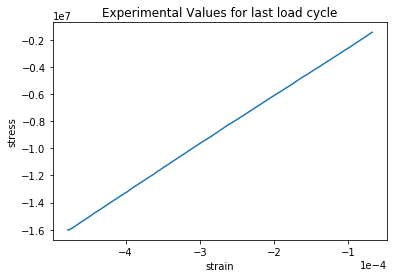

In [12]:
plt.plot(data['strain'],data['stress'])
plt.xlabel('strain')
plt.ylabel('stress')
plt.title('Experimental Values for last load cycle')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [13]:
# 70-30 training and test split
train, test = np.split(data.sample(frac=1, random_state=42), 
                       [int(.7*len(data))])

# 2. Forward Solve

In [14]:
def forward_solve(known_input, latent_para):
    assert isinstance(known_input['known_inputs'],np.ndarray)
    stress = known_input['known_inputs']
    strain = th.tensor(stress)/latent_para
    
    return strain

# 3. Inference Task
- Uniform Prior for the latent variable E
- Gamm hyperprior for the noise term

In [15]:
# -- Metadata for Inference problem
        
prior_hyperparameter = [32E09, 38E09]
prior_dist = "Uniform"
Observed_data = th.tensor(train['strain'].to_numpy())
Noise_distribution = "Normal"
Noise_hyperparameter = None  # TODO: test with correlated noise model
HyperPrior_dist = "Gamma"
Hyperprior_Parameter = [1,1E05]

 # ---- Metadata for forward solve
forward_solve_wrapper = forward_solve
forward_solve_known_input = train['stress'].to_numpy()
forward_input = {'known_inputs':forward_solve_known_input}

# -- Setup the Inference problem
infer = Inference(prior_dist, prior_hyperparameter, forward_solve_wrapper, forward_input, Observed_data,
                  Noise_distribution, Noise_hyperparameter,HyperPrior_dist,Hyperprior_Parameter)

# -- Solve the Inference problem
   
posterior_para, posterior_noise = infer.run(1000, kernel="NUTS")

Sample: 100%|██████████| 2000/2000 [00:10, 185.59it/s, step size=6.25e-01, acc. prob=0.941]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta 32749190854.20 219793676.94 32747786677.75 32388694474.41 33118513858.78    388.92      1.00
     sigma      0.00      0.00      0.00      0.00      0.00    463.50      1.00

Number of divergences: 0


In [ ]:
# The strain values are very small. Need to normalize? What noise hyperprior dist? Their parameters?

## 3.1 Inference Visualisation 

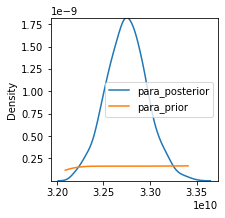

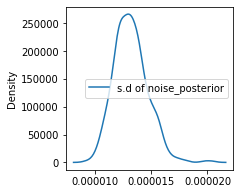

In [16]:
infer.visualize_prior_posterior(posterior_para, posterior_noise)

# 4. Prediction

In [17]:
# known input 
tmp = test['stress'].to_numpy() # AA: Can write a wrapper to read in data if they are in same order (maybe for similar experiment), can also imporrt data from different experiment of the similar specimen
new_input_forward = {'known_inputs': tmp}

til_X = infer.predict(posterior_para,posterior_noise,new_input_forward)

In [18]:
pos=np.quantile(til_X,[0.05,0.5,0.95],axis=0)

Text(0, 0.5, 'stress')

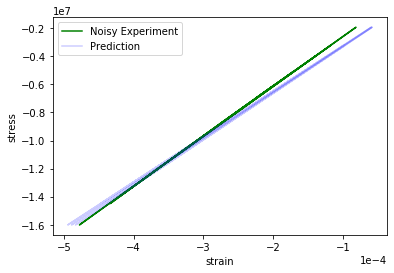

In [19]:
#plt.plot(data['s'],pos[1,:])
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
#plt.fill_betweenx(test['stress'],pos[0,:],pos[2,:],alpha=0.8, label='Predicted strain')
#plt.fill_between(test['stress'],pos[0,:],pos[2,:],alpha=0.8, label='Predicted strain')
plt.plot(test['strain'],test['stress'],'g', label='Noisy Experiment')
plt.plot(pos[1,:],test['stress'],'b',alpha=0.2)
plt.plot(pos[0,:],test['stress'],'b',alpha=0.2,label='Prediction')
plt.plot(pos[2,:],test['stress'],'b',alpha=0.2)
plt.legend()
plt.xlabel('strain')
plt.ylabel('stress')

# Misc

In [ ]:

sampled_parameters = pyro.sample('test', dist.Normal(0, 1))

In [ ]:
for name,value in sampled_parameters:
    print(name,value)

In [ ]:
sampled_parameters.items()